In [221]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt

import pandas as pd


In [222]:
# adapted from ChatGPT

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        # self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [223]:
class DQLAgent:
    def __init__(self, input_size, output_size, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999,
                 target_update_frequency=10, memory_capacity=100000, batch_size=64):
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update_frequency = target_update_frequency
        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.dqn = DQN(input_size, output_size)
        self.target_dqn = DQN(input_size, output_size)
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.target_dqn.eval()
        self.optimizer = torch.optim.Adam(self.dqn.parameters())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1, 2, 3])
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self.dqn(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        q_values = self.dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_dqn(next_states).max(1).values
        target_values = rewards + (1 - dones) * self.gamma * next_q_values
        loss = F.smooth_l1_loss(q_values, target_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def target_update(self, episode):
        if episode % self.target_update_frequency == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())



In [224]:
def matrix_to_tuple(matrix):
    return (matrix[0][1], matrix[0][2], matrix[1][2])

# B is the inverse of A
A = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]])

# C is the inverse of D
C = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = np.array([[1, 0, 0], [0, 1, -1], [0, 0, 1]])

identity = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# together, A, B, C, and D generate the heisenberg group

In [225]:
df = pd.read_csv("../Data_Generation/Data_files/heisenberg_data.csv")

In [226]:
max_reward = 10000
# step_penalty = -100
step_penalty = -10
def getReward(matrix):
    if (matrix==identity).all():
        return max_reward
    else:
        return step_penalty

In [227]:
def tuple_to_matrix(tuple):
    assert len(tuple)==3
    return np.array([
        [1, int(tuple[0]), int(tuple[1])], 
        [0, 1, int(tuple[2])], 
        [0, 0, 1]
        ])

In [228]:
def get_next_step(oldObs, action):
    # action is always either 0, 1, 2, or 3
    next_state = []
    oldObs = tuple_to_matrix(oldObs)

    if action==0:
        next_state = oldObs @ A
    elif action==1:
        next_state = oldObs @ B
    elif action==2:
        next_state = oldObs @ C
    elif action==3:
        next_state = oldObs @ D
    else:
        assert 1==2
    curReward = getReward(next_state)
    done = curReward==max_reward
    return (matrix_to_tuple(next_state), curReward, done)

In [237]:
input_size = 3
output_size = 4

agent2 = DQLAgent(input_size, output_size)

track_rewards = []

for episode in range(4000):
    cur_row = df.sample(1)
    state = (cur_row['val1'].values[0], cur_row['val2'].values[0], cur_row['val3'].values[0])

    total_reward = 0
    for t in range(100):
        action = agent2.select_action(state)
        next_state, reward, done = get_next_step(state, action)
        agent2.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent2.replay()
    agent2.target_update(episode)
    print(f'Episode {episode + 1}, Total Reward: {total_reward}')
    track_rewards.append(total_reward)


Episode 1, Total Reward: -1000
Episode 2, Total Reward: -1000
Episode 3, Total Reward: -1000
Episode 4, Total Reward: -1000
Episode 5, Total Reward: -1000
Episode 6, Total Reward: -1000
Episode 7, Total Reward: -1000
Episode 8, Total Reward: -1000
Episode 9, Total Reward: -1000
Episode 10, Total Reward: -1000
Episode 11, Total Reward: -1000
Episode 12, Total Reward: -1000
Episode 13, Total Reward: -1000
Episode 14, Total Reward: -1000
Episode 15, Total Reward: -1000
Episode 16, Total Reward: -1000
Episode 17, Total Reward: -1000
Episode 18, Total Reward: -1000
Episode 19, Total Reward: -1000
Episode 20, Total Reward: -1000
Episode 21, Total Reward: -1000
Episode 22, Total Reward: -1000
Episode 23, Total Reward: -1000
Episode 24, Total Reward: -1000
Episode 25, Total Reward: -1000
Episode 26, Total Reward: -1000
Episode 27, Total Reward: -1000
Episode 28, Total Reward: -1000
Episode 29, Total Reward: -1000
Episode 30, Total Reward: -1000
Episode 31, Total Reward: -1000
Episode 32, Total

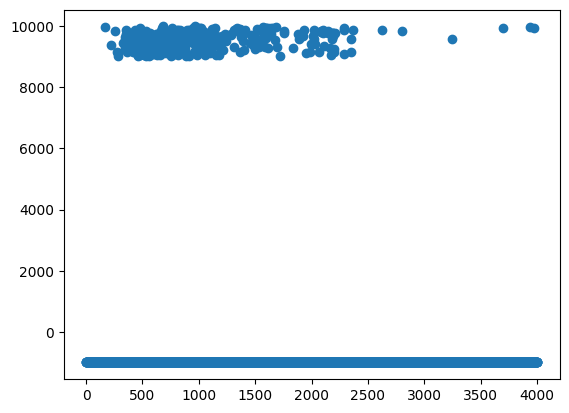

In [238]:
plt.scatter(x=np.arange(1, 1+len(track_rewards)), y=track_rewards)

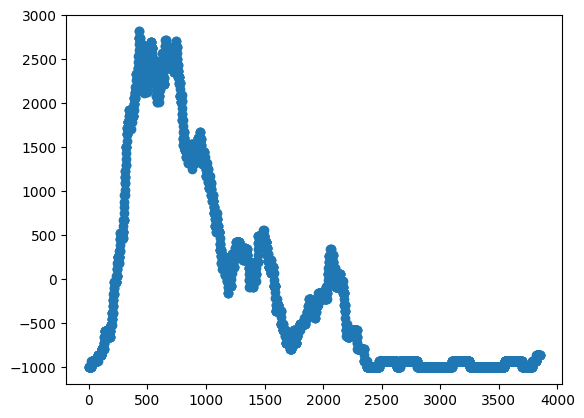

In [240]:
# moving average adapted from ChatGPT
def moving_average(arr, window_size):
    cumsum = np.cumsum(arr)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


window_size = 150
moving_avg = moving_average(track_rewards, window_size)


plt.scatter(x=np.arange(1, 1+len(moving_avg)), y=moving_avg)

# plt.savefig("why_does_performance_worsen.png")
plt.show()

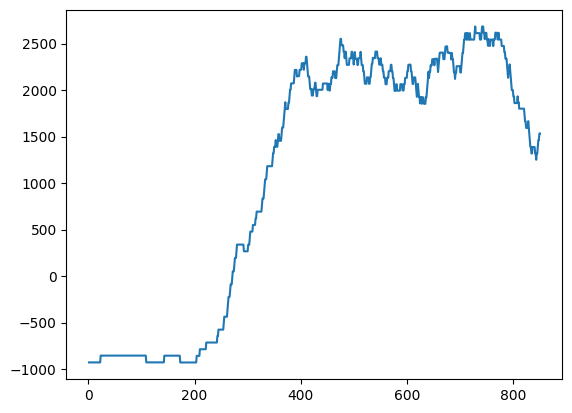

In [232]:
plt.plot(np.arange(1, 1+len(moving_avg)), moving_avg)

In [233]:
len(agent2.memory)

91404

In [234]:
agent2.epsilon

0.3676954247709635

In [235]:
A@A

array([[1, 2, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [236]:
s = (100, 0, 0)
s2 = torch.tensor(s, dtype=torch.float32) 
q_values = agent.dqn(s2)
q_values

tensor([-2814.9937, -2676.1775, -2731.2954, -2731.9546],
       grad_fn=<AddBackward0>)